### 1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [1]:
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def time_format(sec):
    return str(timedelta(seconds=sec))

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=-1,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf, f1_test

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [2]:
def build_dataset_raw(churned_start_date='2019-01-01', 
                      churned_end_date='2019-02-01', 
                      inter_list=[(1,7),(8,14)],
                      raw_data_path='train/',
                      dataset_path='dataset/', 
                      mode='train'):
    
    start_t = time.time()
 
    sample = pd.read_csv('{}sample.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    profiles = pd.read_csv('{}profiles.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    payments = pd.read_csv('{}payments.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    reports = pd.read_csv('{}reports.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    abusers = pd.read_csv('{}abusers.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    logins = pd.read_csv('{}logins.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    pings = pd.read_csv('{}pings.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    sessions = pd.read_csv('{}sessions.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    shop = pd.read_csv('{}shop.csv'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    
    print('Run time (reading csv files): {}'.format(time_format(time.time()-start_t)))    
#-----------------------------------------------------------------------------------------------------    
    print('NO dealing with outliers, missing values and categorical features...')
#-----------------------------------------------------------------------------------------------------        
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом
    
    print('Creating dataset...')
    # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
    if mode == 'train':
        dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
    elif mode == 'test':
        dataset = sample.copy()[['user_id', 'level', 'donate_total']]

    # Пройдемся по всем источникам, содержащим "динамичекие" данные
    for df in [payments, reports, abusers, logins, pings, sessions, shop]:

        # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
        data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
        data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - 
                                data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.days)
        df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

        # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
        features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
        print('Processing with features:', features)
        for feature in features:
            for i, inter in enumerate(inter_list):
                inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)].\
                                groupby('user_id')[feature].mean().reset_index().\
                                rename(index=str, columns={feature: feature+'_{}'.format(i+1)})
                df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

        # Добавляем построенные признаки в датасет
        dataset = pd.merge(dataset, df_features, how='left', on='user_id')
        
        print('Run time (calculating features): {}'.format(time_format(time.time()-start_t)))

    # Добавляем "статические" признаки
    dataset = pd.merge(dataset, profiles, on='user_id')
#---------------------------------------------------------------------------------------------------------------------------
    dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', index=False)
    print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'.\
          format(dataset_path, time_format(time.time()-start_t)))

In [9]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = [1,7]
INTER_2 = [8,14]
INTER_3 = [15,21]
INTER_4 = [22,28]
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

raw_data_path = 'G:/data/ML-system-in-Production/'
dataset_path='G:/data/ML-system-in-Production/dataset/'

In [10]:
def prepare_dataset(dataset, 
                    dataset_type='train',
                    dataset_path=dataset_path):
    print(dataset_type)
    start_t = time.time()
    print('Dealing with missing values, outliers, categorical features...')
    
    # Профили
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['gender'] = dataset['gender'].fillna(dataset['gender'].mode()[0])
    dataset.loc[~dataset['gender'].isin(['M', 'F']), 'gender'] = dataset['gender'].mode()[0]
    dataset['gender'] = dataset['gender'].map({'M': 1., 'F':0.})
    dataset.loc[(dataset['age'] > 80) | (dataset['age'] < 7), 'age'] = round(dataset['age'].median())
    dataset.loc[dataset['days_between_fl_df'] < -1, 'days_between_fl_df'] = -1
    # Пинги
    for period in range(1,len(INTER_LIST)+1):
        col = 'avg_min_ping_{}'.format(period)
        dataset.loc[(dataset[col] < 0) | 
                    (dataset[col].isnull()), col] = dataset.loc[dataset[col] >= 0][col].median()
    # Сессии и прочее
    dataset.fillna(0, inplace=True)
    dataset.to_csv('{}dataset_{}.csv'.format(dataset_path, dataset_type), sep=';', index=False)
         
    print('Dataset is successfully prepared and saved to {}, run time (dealing with bad values): {}'.\
          format(dataset_path, time_format(time.time()-start_t))) 

In [11]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path=raw_data_path + 'train/',
                  dataset_path=dataset_path, 
                  mode='train')

Run time (reading csv files): 0:00:52.268215
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:01:11.120504
Processing with features: ['reports_amt']
Run time (calculating features): 0:02:17.698254
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:05:37.057280


KeyboardInterrupt: 

In [ ]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path=raw_data_path + 'test/',
                  dataset_path=dataset_path, 
                  mode='test')

In [12]:
train = pd.read_csv('G:/data/ML-system-in-Production/dataset/dataset_raw_train.csv', sep=';')
test = pd.read_csv('G:/data/ML-system-in-Production/dataset/dataset_raw_test.csv', sep=';')

In [13]:
prepare_dataset(dataset=train, dataset_type='train')
prepare_dataset(dataset=test, dataset_type='test')

train
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to G:/data/ML-system-in-Production/dataset/, run time (dealing with bad values): 0:00:19.470024
test
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to G:/data/ML-system-in-Production/dataset/, run time (dealing with bad values): 0:00:01.851181


In [5]:
dataset = pd.read_csv('G:/data/Системы машинного обучения в Production/dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']
X_mm = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

In [6]:
# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

In [7]:
%%time
f1_dict = {}
fitted_clf, f1_dict['All Features'] = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = pd.DataFrame(list(zip(X.columns, fitted_clf.feature_importances_))).sort_values(by=1, ascending=False)

Precision: 0.29131697869593287
Recall: 0.43514946962391515
F1: 0.3489945862335654
Log Loss: 0.13393280093886964
ROC AUC: 0.8998371433309056
Wall time: 17.5 s


In [8]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_FI, f1_dict['Feature Importance'] = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.2942614933159439
Recall: 0.43514946962391515
F1: 0.3510990079751022
Log Loss: 0.13236732478673477
ROC AUC: 0.8977925184713393
Признаков было: 60
Признаков стало: 30


##### Взаимная информация

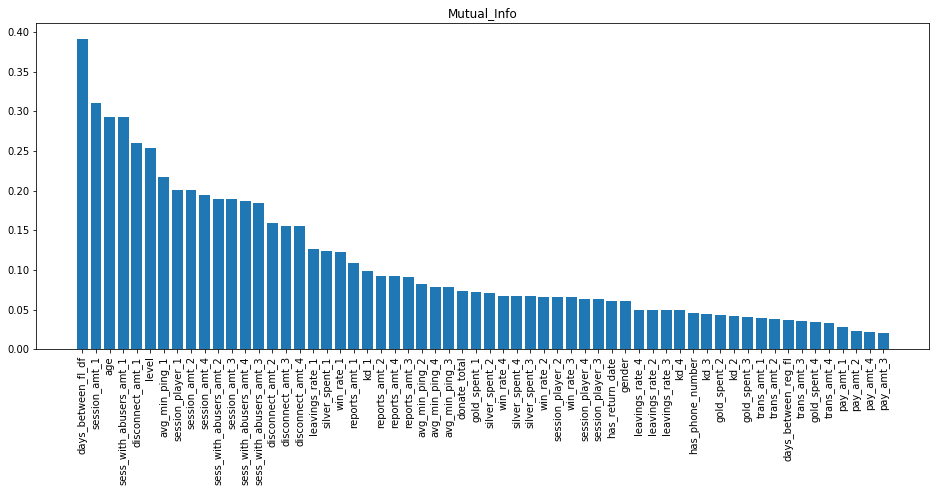

Wall time: 5min 24s


In [9]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [10]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_MI, f1_dict['Mutual Information'] = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_MI.shape[1])

Precision: 0.29105993904503896
Recall: 0.4144165863066538
F1: 0.3419534513626417
Log Loss: 0.13371803624952866
ROC AUC: 0.8951783551376775
Признаков было: 60
Признаков стало: 30


##### RFE (Recursive Feature Elimination)

In [11]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1', n_jobs=-1)
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 45
Wall time: 51.5 s


In [12]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_RFE, f1_dict['Recursive Feature Elimination'] = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_RFE.shape[1])

Precision: 0.2933665008291874
Recall: 0.4264705882352941
F1: 0.34761249754372175
Log Loss: 0.13259966897581332
ROC AUC: 0.8998921466865731
Признаков было: 60
Признаков стало: 45


##### Permutation Importance (PI)

In [13]:
from eli5.sklearn import PermutationImportance

In [14]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Wall time: 3min 33s


In [18]:
X_train_PI = pd.DataFrame(X_train_balanced, columns=X.columns)[list(res["feature"][0:30])]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[list(res["feature"][0:30])]

fitted_clf_PI, f1_dict['Permutation Importance'] = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_PI.shape[1])

Precision: 0.28633443306129536
Recall: 0.3975409836065574
F1: 0.33289593216917335
Log Loss: 0.13452745523834686
ROC AUC: 0.8967014864583018
Признаков было: 60
Признаков стало: 30


In [19]:
f1_dict

{'All Features': 0.3489945862335654,
 'Feature Importance': 0.3510990079751022,
 'Mutual Information': 0.3419534513626417,
 'Recursive Feature Elimination': 0.34761249754372175,
 'Permutation Importance': 0.33289593216917335}

##### 2. Обучите любые две другие модели для предсказания оттока на любом из отобранных множеств признаков и сравните качество с уже полученными.

Precision: 0.2942614933159439

Recall: 0.43514946962391515

F1: 0.3510990079751022

Log Loss: 0.13236732478673477

ROC AUC: 0.8977925184713393

In [22]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [23]:
%%time
rfc_clf = RandomForestClassifier(n_estimators=200,
                                 max_depth=7,
                                 min_samples_split=10,
                                 random_state=42,
                                 n_jobs=-1)

rfc_clf.fit(X_train_FI, y_train_balanced)
predict_proba_test = rfc_clf.predict_proba(X_test_FI)
predict_test = rfc_clf.predict(X_test_FI)
metrics = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2675739792733175
Recall: 0.5166345226615237
F1: 0.3525540840667928
Log Loss: 0.16187552874091135
ROC AUC: 0.9058351377961262
Wall time: 29 s


In [24]:
%%time
catboost_clf = CatBoostClassifier(iterations=300,
                                  depth=5,
                                  learning_rate=1e-2,
                                  silent=True,
                                  random_state=42,
                                  thread_count=-1)

catboost_clf.fit(X_train_FI, y_train_balanced)
predict_proba_test = catboost_clf.predict_proba(X_test_FI)
predict_test = catboost_clf.predict(X_test_FI)
metrics = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.30642978003384097
Recall: 0.436595949855352
F1: 0.3601113541459535
Log Loss: 0.1440337939965131
ROC AUC: 0.897236544111342
Wall time: 16.7 s


Вывод: Значения метрик идут рядом, с учетом без подбора параметров

По F1 выиграл CatBoost.

По Log Loss XGBoost

Площадь под ROC-кривой больше у RFC

##### 3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [25]:
import seaborn as sns

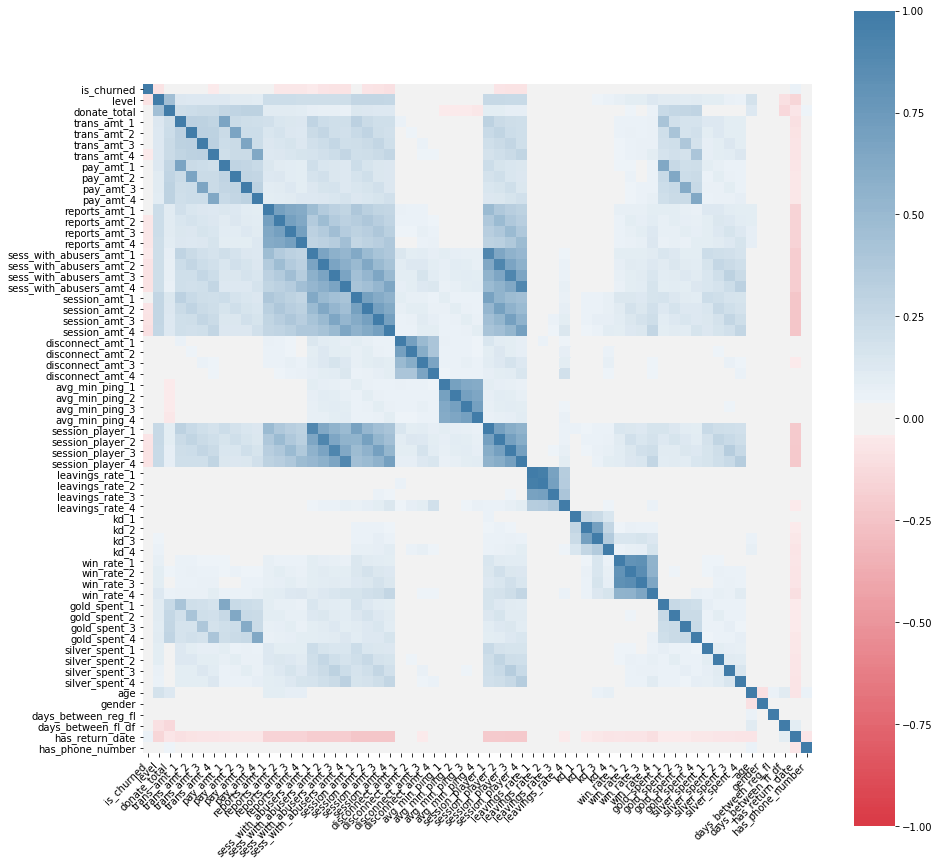

In [26]:

corr = dataset.drop(['user_id'], axis=1).corr()

plt.figure(figsize=(15, 15))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 240, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

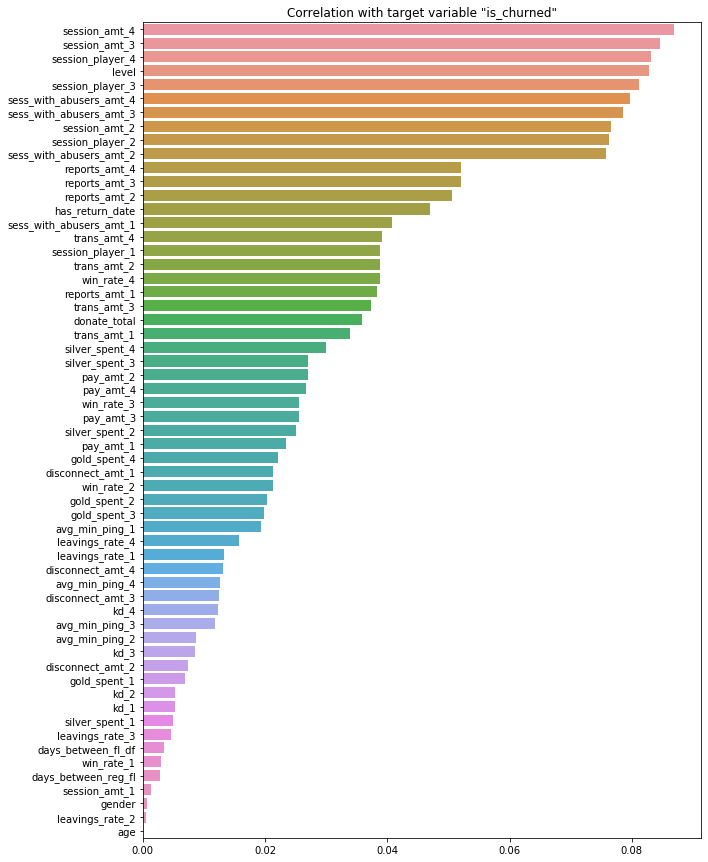

In [28]:
corr_with_target = np.abs(corr.iloc[:-1, 0].drop('is_churned')).sort_values(ascending=False)

plt.figure(figsize=(10, 15))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable "is_churned"')
plt.show()

In [29]:
X_train_CORR = pd.DataFrame(X_train_balanced, columns=X.columns)[corr_with_target[:35].index]
X_test_CORR = pd.DataFrame(X_test, columns=X.columns)[corr_with_target[:35].index]

fitted_clf_CORR, f1_dict['Correlation'] = xgb_fit_predict(X_train_CORR, y_train_balanced, X_test_CORR, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_CORR.shape[1])

Precision: 0.28803861970320044
Recall: 0.38837994214079075
F1: 0.33076686171850944
Log Loss: 0.14399806704244253
ROC AUC: 0.8379618769559369
Признаков было: 60
Признаков стало: 35
